## 乗算レイヤー

In [1]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        return out
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        
        return dx, dy

In [2]:
apple = 100
apple_num = 2
tax = 1.1

### layer

In [3]:
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

### forward

In [4]:
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

In [5]:
price

220.00000000000003

### backward

In [6]:
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

In [7]:
(dapple, dapple_num, dtax)

(2.2, 110.00000000000001, 200)

## 加算レイヤー

In [8]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

In [9]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

### layer

In [10]:
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

### forward

In [11]:
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

In [12]:
price

715.0000000000001

### backward

In [13]:
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

In [14]:
(dapple, dapple_num, dorange, dorange_num, dtax)

(2.2, 110.00000000000001, 3.3000000000000003, 165.0, 650)

## Relu

In [15]:
import numpy as np

In [16]:
class Relu:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

In [17]:
x = np.array([[1.0, -0.5], [-2.0, 3.0]])
(x <= 0)

array([[False,  True],
       [ True, False]], dtype=bool)

## Sigmoid

In [18]:
class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        
        return dx

In [19]:
X = np.random.rand(2)
W = np.random.rand(2, 3)
B = np.random.rand(3)

In [20]:
X.shape

(2,)

In [21]:
W.shape

(2, 3)

In [22]:
B.shape

(3,)

In [23]:
Y = np.dot(X, W) + B
Y.shape

(3,)

In [24]:
X_dot_W = np.array([[0, 0, 0], [10, 10, 10]])
B = np.array([1, 2, 3])

In [25]:
X_dot_W + B

array([[ 1,  2,  3],
       [11, 12, 13]])

In [26]:
dY = np.array([[1, 2, 3], [4, 5, 6]])

In [27]:
dB = np.sum(dY, axis=0)
dB

array([5, 7, 9])

In [28]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx

In [29]:
from common.functions import softmax, cross_entropy_error

In [30]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

In [31]:
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

In [37]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, 
                weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
            
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, acis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

In [34]:
from dataset.mnist import load_mnist

In [35]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

In [38]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [39]:
x_batch = x_train[:3]
t_batch = t_train[:3]

In [40]:
grad_numerical = network.numerical_gradient(x_batch, t_batch)

In [41]:
grad_backprop = network.gradient(x_batch, t_batch)

In [42]:
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:2.14890239345e-13
b1:8.16454107013e-13
W2:8.68228468992e-13
b2:1.19237957008e-10


In [43]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [44]:
iter_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

In [45]:
train_loss_list = []
train_acc_list = []
test_acc_list = []

In [47]:
iter_per_epoch = max(train_size // batch_size, 1)

In [48]:
for i in range(iter_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # backprop
    grad = network.gradient(x_batch, t_batch)
    
    # update
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.124316666667 0.1146
0.903116666667 0.9053
0.925433333333 0.9269
0.936916666667 0.9373
0.945333333333 0.9442
0.9526 0.9487
0.957616666667 0.9553
0.961666666667 0.9584
0.965816666667 0.9612
0.966033333333 0.9596
0.9708 0.9639
0.97305 0.9664
0.97405 0.9656
0.973933333333 0.965
0.9774 0.9678
0.978283333333 0.9686
0.97955 0.9702


In [49]:
final_train_acc = network.accuracy(x_train, t_train)
final_test_acc = network.accuracy(x_test, t_test)
train_acc_list.append(final_train_acc)
test_acc_list.append(final_test_acc)
print(final_train_acc, final_test_acc)

0.981033333333 0.969


In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

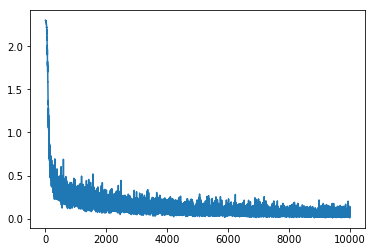

In [55]:
plt.plot(list(range(len(train_loss_list))), train_loss_list)

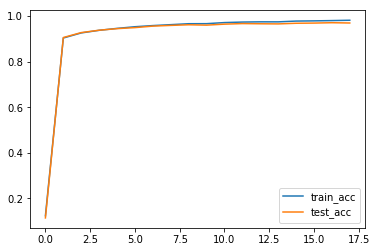

In [57]:
x1 = list(range(len(train_acc_list)))
plt.plot(x1, train_acc_list, label="train_acc")
plt.plot(x1, test_acc_list, label="test_acc")
plt.legend()